In [15]:
#near duplicate detection and elimination
#next steps - obtain more data
#near entity recognition - spacy
#relabeling

# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [16]:
data_path = '../data/training_test_data/'
data = pd.read_csv(data_path + 'after_stock_data_cleaned.csv')
data3 = pd.concat([pd.read_csv(data_path + 'arkadium201907051117.csv')
                  , pd.read_csv(data_path + 'chief outsiders201907051119.csv')
                  , pd.read_csv(data_path + 'choice one engineering201907051119.csv')
                  , pd.read_csv(data_path + 'community impact newspaper201907051127.csv')
                  , pd.read_csv(data_path + 'evergreen real estate201907051128.csv')
                  , pd.read_csv(data_path + 'fbs data systems201907051131.csv')
                  , pd.read_csv(data_path + 'GREAT LAKES BREWING COMPANy201907051146.csv')
                  , pd.read_csv(data_path + 'HARVEST GROUP201907051148.csv')])                  
colnames = ['headline','source','label']   
data.columns = colnames

data = pd.concat([data,data3], sort=False)

data2 = pd.read_csv(data_path + 'now_data_parsed.csv')

data2.columns = ['headline','label']

#getting data we have labeled out of the unlabeled data

data2_labeled = pd.concat([data2[438:2438], data2[6448:8448],data2[12458:14458],data2[18468:20709],data2[24478:26479]], sort=False)

data4 = pd.read_csv(data_path + 'stock_news_201907102113.csv')

In [17]:
#concatenate our data to their data

from sklearn.utils import shuffle

data = pd.DataFrame({'headline':data['headline'], 'label':data['label']}, columns=['headline', 'label'])

df_union = shuffle(pd.concat([data, data2_labeled, data4], sort=False))

In [18]:
#this is less balanced now with the addition of new data and new labeling rules
df_union['label'].value_counts()

1    12692
0     2788
Name: label, dtype: int64

In [19]:
import re

df_union['headline'] = df_union['headline'].str.replace("[^a-zA-Z]", " ")

In [20]:
word_count = sum(len(headline.split(' ')) for headline in df_union['headline'])

print(word_count)

252488


In [21]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_union[['label','headline']], stratify = df_union['label'], test_size = 0.2, random_state = 12)
print('{}, {}'.format(len(df_trn), len(df_val)))

12384, 3096


In [22]:
unlabeled_headlines = pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\raw_data\Nowigence Raw Data.csv')

unlabeled_headlines.columns = ['headline']

text_df = pd.DataFrame(pd.concat([data['headline'], data2['headline']]))
text_df['label'] = 0

txt_trn, txt_val = train_test_split(text_df[['label','headline']], stratify = text_df['label'], test_size = 0.2, random_state = 12)

print('{}, {}'.format(len(txt_trn), len(txt_val)))

text_df.head()

28005, 7002


,headline,label
0,"Apple, Amazon, YouTube: Safer, faster &amp; le...",0
1,5G Stocks: Will Amazon Dip Its Toes In?,0
2,Fear of Amazon Creates a Bargain in FedEx Stock,0
3,Amazon Buyout Buzz Draws Options Bulls to Grub...,0
4,US Stock Market Overview – Stocks Surge With O...,0


In [23]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = txt_trn, valid_df = txt_val, path = "", num_workers = 0)

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, num_workers = 0)

In [24]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7)

In [25]:
#finding a learning rate for the language model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [11]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,7.075545,5.553322,0.172519,31:03
1,5.537834,4.776069,0.245046,31:49
2,4.849088,4.529498,0.268527,30:02
3,4.465676,4.425116,0.279833,26:04
4,4.267784,4.411620,0.281550,25:23


In [ ]:
#I probably don't need to import all of these...I'll do more research to figure out just what I'm using below

from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback

#based on fastai's built in fbeta and accuracy metrics - the fbeta that is built in only works on one hot encoded multiclass targets

def fscore(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    n = y_true.shape[0]
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = y_pred.argmax(dim=-1).view(n,-1)
    y_true = y_true.view(n,-1)
    TP = (y_pred*y_true).float().sum()
    prec = TP/(y_pred.float().sum()+eps)
    rec = TP/(y_true.float().sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.float().mean()

In [10]:
from fastai import metrics

#learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.load('ulmfit_export')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12384 items)
x: TextList
xxbos xxmaj the best free things to do in xxmaj dublin from botanic gardens to xxunk centres,xxbos xxmaj west xxmaj japan xxunk xxmaj china at xxup un for xxunk of xxmaj xxunk,xxbos u s probe of xxmaj google s online ad dominance would xxunk long suffering rivals publishers,xxbos amazon aids workers freight firms,xxbos xxmaj china xxmaj box xxmaj office xxmaj aladdin xxmaj opens on xxmaj top xxmaj with xxmaj million xxmaj weekend
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (3096 items)
x: TextList
xxbos xxmaj the xxmaj xxunk podcast xxmaj after xxmaj life star xxmaj ricky xxmaj gervais wants you to xxunk up,xxbos xxup abc xxmaj stations xxmaj helped xxmaj trump xxmaj build a xxmaj campaign xxmaj email xxmaj list on xxmaj his xxmaj birthday,xxbos google demos ondevice assistant that speeds up commands by up to x,xxbos amazon will soar by if its retail business is valued like,xxbos shareholder efforts

In [11]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.377814,0.312977,0.867248,20:45


In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.387849,0.307557,0.865956,22:38


In [13]:
error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
#predictions = learn.get_preds()
#learn.show_results()
#error_analysis.head()


In [11]:
learn.predict("Gambling Stock Roundup: WYNN to Sell Massachusetts Casino, DIS &amp; CZR Ink Deal")

C:\ProgramData\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category 0, tensor(0), tensor([0.5086, 0.4914]))

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[(0, 1, 320), (1, 0, 95)]

In [18]:
predictions[:5]

[tensor([[0.1373, 0.8627],
         [0.0761, 0.9239],
         [0.2078, 0.7922],
         ...,
         [0.1996, 0.8004],
         [0.1028, 0.8972],
         [0.1433, 0.8567]]), tensor([1, 1, 1,  ..., 1, 1, 1])]

In [ ]:
learn.show_results(5)

In [13]:
learn.export('models/final_model.pkl')
#torch.save(learn, r'models\ulmfit_export')
#learn.export('ulm_clas_exp')

In [14]:
with open('models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)

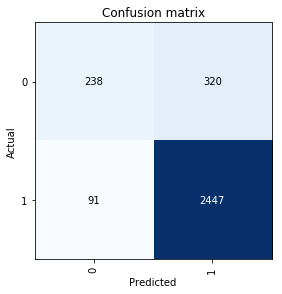

In [12]:
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.plot_confusion_matrix()

In [ ]:
from sklearn.metrics import f1_score, precision, recall

print(f1_score())


In [ ]:
txt_ci.show_top_losses(10)

In [ ]:
params = hkl.load('resnet-18-export.hkl')

# convert numpy arrays to torch Variables
for k in sorted(params.keys()):
    v = params[k]
    print(k, v.shape)
    params[k] = Variable(torch.from_numpy(v), requires_grad=True)

In [14]:
import warnings
warnings.filterwarnings('ignore')

error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
error_analysis.head()

ulmfit_preds = error_analysis['headline'].apply(lambda row: str(learn.predict(row)[0]))

print(ulmfit_preds[:5])
#learn.predict("This was a great movie!")

0    1
1    0
2    0
3    1
4    1
Name: headline, dtype: object


In [16]:
error_analysis['ulmfit_classification'] = ulmfit_preds

error_analysis.head()

,Unnamed: 0,headline,actual_classification,logistic_regression_classification,xgboost_classification,ulmfit_classification
0,2305,apex nc google reputation management negative ...,1,1,1,1
1,284,Gambling Stock Roundup: WYNN to Sell Massachus...,0,0,0,0
2,814,World shares skid after technology sell-off hi...,0,1,1,0
3,13079,star trek picardis coming to amazon prime in i...,1,1,1,1
4,1570,amazon canada silicon power 512gb 3d nand sata...,1,1,1,1


In [18]:
error_analysis.to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv")